In [1]:
#MAIN LOOP - where we run the simulations to figure out statistical significance of changes

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import netCDF4 as nc
import matplotlib.pyplot as plt
%matplotlib notebook
%load_ext autotime
from bootstrap import *
from shutil import copyfile

In [2]:
## BE CAREFUL which source file is being used - here, we use a zonal average that excludes taiwan.
ferretpath = "/Users/Siwen/Desktop/ferret/bin/"
ff = "Pchina_type_notaiwan.nc"
filename = ferretpath + ff
myf = nc.Dataset(filename, 'r')

time: 8.82 ms


In [3]:
P_total =  myf.variables['Pchina_total'][:]
P_band = myf.variables['Pchina_band'][:]
P_local = myf.variables['Pchina_local'][:]

time: 83.6 ms


In [4]:
def smooth(P,dayrange,latrange):
    Psmooth=np.zeros(P.shape)
    
    ll=int((dayrange-1)/2)
    yy=int((latrange-1)/2)
    
    days = P.shape[0]
    lats = P.shape[1]
    
    for d in range(days):
        for j in range(lats):
            
            Psample = P.take(range(d-ll,d+ll+1), mode='wrap', axis=0)
            Ps = Psample[:,max(0,j-yy):min(days,j+yy+1)]
            Psmooth[d,j] = np.mean(np.mean(Ps))
    
    return Psmooth

time: 6.92 ms


In [5]:
#years of interest - start and end date, with index starting at 1 out of habit.
p1_yr_b = [1,30]
p1_yr_e = [29,43]
p2_yr_b = [30,44]
p2_yr_e = [57,57]

P_total_diff = []
P_band_diff = []
P_local_diff = []

#cycle through all time periods of interest and find changes in each type of rainfall b/w periods
for p1_b, p1_e, p2_b, p2_e, i in zip(p1_yr_b, p1_yr_e, p2_yr_b, p2_yr_e, np.arange(len(p1_yr_b))): 
    
    P_total_diff.append(np.mean(P_total[:,:,p2_b-1:p2_e], axis=2) - \
                         np.mean(P_total[:,:,p1_b-1:p1_e], axis=2))
    P_band_diff.append(np.mean(P_band[:,:,p2_b-1:p2_e], axis=2) \
                       - np.mean(P_band[:,:,p1_b-1:p1_e], axis=2))
    P_local_diff.append(np.mean(P_local[:,:,p2_b-1:p2_e], axis=2) \
                        - np.mean(P_local[:,:,p1_b-1:p1_e], axis=2))

time: 19.5 ms


In [6]:
## SMOOTHING ##
#smooth out the decadal precipitation means
#but, no latitudinal smoothing since rainfall already effectively smoothed in latitude
daysmth = 15
latsmth = 0

#one line! thank you python!
P_total_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_total_diff ]
P_band_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_band_diff ]
P_local_diff_smth = [ smooth(x,daysmth,latsmth) for x in P_local_diff ]

time: 4.06 s


<IPython.core.display.Javascript object>


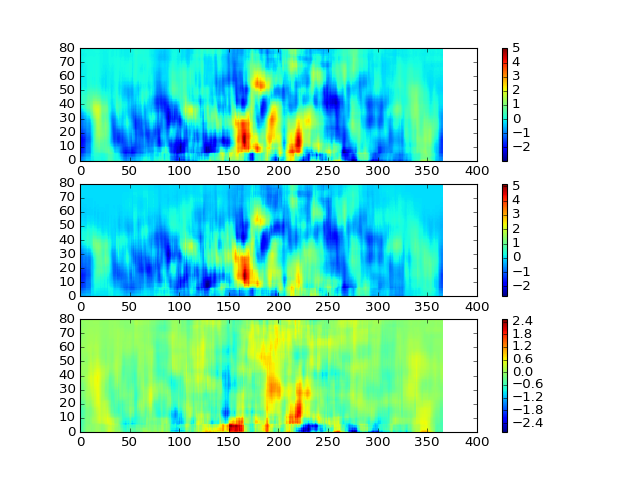

time: 336 ms


In [7]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
plt.pcolormesh(P_total_diff_smth[1].T)
plt.colorbar()

ax2 = fig.add_subplot(312)
plt.pcolormesh(P_band_diff_smth[1].T)
plt.colorbar()

ax3 = fig.add_subplot(313)
plt.pcolormesh(P_local_diff_smth[1].T)
plt.colorbar()

In [13]:
## BOOTSTRAPPING ##
#from previous testing, determined that the autocorrelation time scale of rainfall is between
#2 and 3 days. Will test both and see effect on p-values.

#General expectation would be that longer block lengths will lead to fewer significant p-values
#(smaller effective sample size

##REWRITTEN SEPTEMBER 26, 2016
#previous version had to run for potentially days at a time, whereas now it saves each new row as it completes it.

#daysmth is defined above
niter = 2000 #how many iterations each time?
blklen = 2
row_increment = 40 #how many rows to run at a time?

p1_b = 30
p1_e = 43
p2_b = 44
p2_e = 57

filepath = "chinarain_diff_pval_notaiwan_"
backuppath = "/Users/Siwen/Desktop/Ferret/bin/"

#netCDF output file formatting formatting
yearsout = str(p1_b+50) + str(p1_e+50) + "_" + str(p2_b+50) + str(p2_e+50) + "_"
fullname = filepath + yearsout + "total" + "_" + str(blklen) +"day_" + str(niter) + "iter.nc"
backupname = backuppath + fullname

##the following is only to make sure that we don't exceed the bounds of the number of rows of actual data.
if os.path.isfile(fullname):
    
    fileout = nc.Dataset(fullname, "r")
    start_row = fileout.lastrow + 1
    fileout.close()

else:
    
    start_row = 0
    
rows = min(row_increment,P_band.shape[1]-start_row) #don't want to keep running the loop past the final row

#P-VALUES OF TOTAL RAINFALL
for i in range(rows):
    
    pval = bs_diff_rain_save(P_total,[p1_b,p1_e],[p2_b,p2_e],daysmth,niter,blklen,fullname,1,'a')
    
    #backup to external directory
    if os.path.exists(backupname):
        os.remove(backupname)
    copyfile(fullname, backupname) #backs file up in case of corruption

Appending to existing file
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270